In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

## Most Important
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
from PIL import Image
import scipy

## less Important
from functools import partial
import os
from scipy import stats
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

## Sklearn
from sklearn import datasets
## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
## Metrics
from sklearn.metrics import accuracy_score

## tensorflow & Keras
import tensorflow as tf    ## i will use tf for every thing and for keras using tf.keras
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Reading Data

In [2]:
train_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
train_images = Path(r'../input/arabic-hwr-ai-pro-intake1/train')

## read these all training images paths as Series
train_images_paths = pd.Series(sorted(list(train_images.glob(r'*.png'))), name='Filepath').astype(str)

train_images_paths.head()

0    ../input/arabic-hwr-ai-pro-intake1/train/00000...
1    ../input/arabic-hwr-ai-pro-intake1/train/00001...
2    ../input/arabic-hwr-ai-pro-intake1/train/00002...
3    ../input/arabic-hwr-ai-pro-intake1/train/00003...
4    ../input/arabic-hwr-ai-pro-intake1/train/00004...
Name: Filepath, dtype: object

# Explore the data

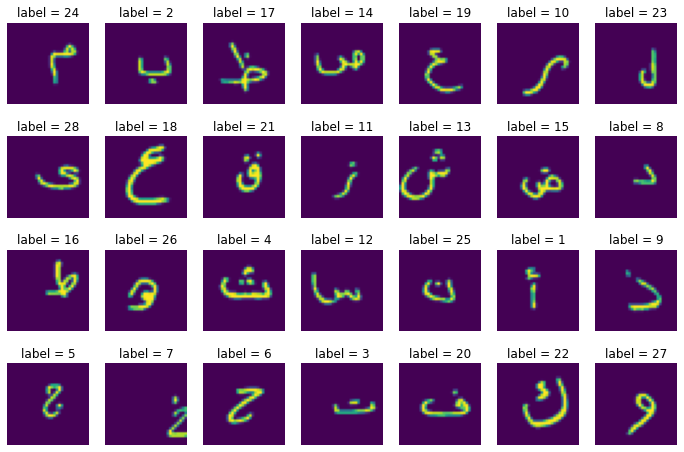

In [3]:
img_key_value = {}
for value in train_labels['label'].unique():
    img_key_value[value] = train_labels[train_labels['label']==value].index[0]
    
img_index = list(img_key_value.values())
img_label = list(img_key_value.keys())

fig, ax = plt.subplots(4, 7, figsize=(12, 8))

i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        plt.title(f'label = {img_label[i]}')
        img = plt.imread(train_images_paths.iloc[img_index[i]])
        plt.imshow(img)
        plt.axis('off')
        i+=1

In [4]:
# know th shape 
print('Number of Instances in train_set =>', len(train_images_paths))
print('Number of Instances in train_labels =>', len(train_labels))

print()

img = plt.imread(train_images_paths.iloc[img_index[0]])
print('shape of each Image is =>', img.shape)

Number of Instances in train_set => 13440
Number of Instances in train_labels => 13440

shape of each Image is => (32, 32, 4)


# Data Preprocessing

In [5]:
train_full_labels = train_labels['label'].values
train_full_set = np.empty((13440, 32, 32, 3), dtype=np.float32)  #take only the first 2 channels

for idx, path in enumerate(train_images_paths):
    img = plt.imread(path)
    img = img[:,:,:3]
    train_full_set[idx] = img
    
print('train_full_set.shape =>', train_full_set.shape)
print('train_full_labels.shape =>', train_full_labels.shape)

train_full_set.shape => (13440, 32, 32, 3)
train_full_labels.shape => (13440,)


# Split the data

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train_full_set, train_full_labels, 
                                                      test_size=0.2, shuffle=True, random_state=42)

print('X_train.shape =>', X_train.shape)
print('X_valid.shape =>', X_valid.shape)
print('y_train.shape =>', y_train.shape)
print('y_valid.shape =>', y_valid.shape)

X_train.shape => (10752, 32, 32, 3)
X_valid.shape => (2688, 32, 32, 3)
y_train.shape => (10752,)
y_valid.shape => (2688,)


In [7]:
#Onehot Encoding the labels.
import keras
import keras.utils
from keras import utils as np_utils
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical



#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_valid=to_categorical(y_valid)

#Verifying the dimension after one hot encoding
print((X_train.shape,y_train.shape))
print((X_valid.shape,y_valid.shape))

((10752, 32, 32, 3), (10752, 29))
((2688, 32, 32, 3), (2688, 29))


# Model training

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,AveragePooling2D


In [9]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu',input_shape=(32, 32, 3)),
#     tf.keras.layers.MaxPooling2D(pool_size=2),
    
#     tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=2),
    
#     tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', ),
#     tf.keras.layers.MaxPooling2D(pool_size=2),
    
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(29, activation='softmax')
 
# ])

In [10]:
allow_soft_placement=True


In [11]:
nets = 5
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape=(32, 32, 3)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Second Layer of CNN
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Third layer of CNN
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))

    #Output layer
    model[j].add(Dense(29, activation='softmax'))

    # Compile each model
    model[j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

2021-11-07 19:04:36.520315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 19:04:36.627590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 19:04:36.628470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 19:04:36.630423: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model

In [13]:
len(model)

5

In [14]:
# Generate batches of tensor image data with real-time data augmentation more detail: https://keras.io/preprocessing/image/
datagen = ImageDataGenerator(rotation_range=2, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train)

In [15]:
batch_size = 32 # Handle 32 pictures at each round
epochs = 240 

In [16]:
for j in range(5):
    print(f'Individual Net : {j+1}')   
    model[j].fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                                        epochs = epochs, steps_per_epoch=X_train.shape[0] // batch_size,
                                        validation_data = (X_valid,y_valid), 
                                        callbacks=[ReduceLROnPlateau(monitor='loss', patience=3, factor=0.1)], 
                                        verbose=2)

Individual Net : 1
Epoch 1/240


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-07 19:04:40.409876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-07 19:04:42.122087: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


336/336 - 13s - loss: 2.5626 - accuracy: 0.2802 - val_loss: 4.8092 - val_accuracy: 0.0930
Epoch 2/240
336/336 - 6s - loss: 1.2299 - accuracy: 0.5842 - val_loss: 1.3732 - val_accuracy: 0.5573
Epoch 3/240
336/336 - 6s - loss: 0.8060 - accuracy: 0.7330 - val_loss: 1.0045 - val_accuracy: 0.6983
Epoch 4/240
336/336 - 7s - loss: 0.5727 - accuracy: 0.8121 - val_loss: 2.4431 - val_accuracy: 0.5227
Epoch 5/240
336/336 - 7s - loss: 0.4999 - accuracy: 0.8344 - val_loss: 0.4364 - val_accuracy: 0.8724
Epoch 6/240
336/336 - 6s - loss: 0.4260 - accuracy: 0.8663 - val_loss: 0.8240 - val_accuracy: 0.7426
Epoch 7/240
336/336 - 7s - loss: 0.3716 - accuracy: 0.8780 - val_loss: 10.7464 - val_accuracy: 0.1894
Epoch 8/240
336/336 - 6s - loss: 0.3372 - accuracy: 0.8943 - val_loss: 3.1490 - val_accuracy: 0.4665
Epoch 9/240
336/336 - 7s - loss: 0.3048 - accuracy: 0.9037 - val_loss: 0.4961 - val_accuracy: 0.8434
Epoch 10/240
336/336 - 6s - loss: 0.2894 - accuracy: 0.9116 - val_loss: 0.2485 - val_accuracy: 0.9289

In [17]:
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [18]:
# history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
#                     epochs=10, batch_size=32, callbacks=[early_stopp])

In [19]:
model

# Evaluate on test set

In [20]:
test_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/test.csv')
test_images = Path(r'../input/arabic-hwr-ai-pro-intake1/test')

## read these all training images paths as Series
test_images_paths = pd.Series(sorted(list(test_images.glob(r'*.png'))), name='Filepath').astype(str)

test_images_paths.head()

0    ../input/arabic-hwr-ai-pro-intake1/test/00000.png
1    ../input/arabic-hwr-ai-pro-intake1/test/00001.png
2    ../input/arabic-hwr-ai-pro-intake1/test/00002.png
3    ../input/arabic-hwr-ai-pro-intake1/test/00003.png
4    ../input/arabic-hwr-ai-pro-intake1/test/00004.png
Name: Filepath, dtype: object

In [21]:
print('Number of Instances in test_set is', len(test_images_paths))


Number of Instances in test_set is 3360


In [22]:
test_full_set = np.empty((3360, 32, 32, 3), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(test_images_paths):
    img = plt.imread(path)
    img = img[:,:,:3]
    test_full_set[idx] = img
    
print('test_full_set.shape =>', test_full_set.shape)

test_full_set.shape => (3360, 32, 32, 3)


In [23]:
# y_preds_classes = np.argmax(model.predict(test_full_set), axis=-1)
# Predict labels with models
labels = []
for m in model:
    predicts = np.argmax(m.predict(test_full_set), axis=1)
    labels.append(predicts)
    
# Ensemble with voting
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))
labels = scipy.stats.mode(labels, axis=1)[0]
labels = np.squeeze(labels)


In [24]:
labels.shape

(3360,)

In [25]:
test_labels['label'] = labels

In [26]:
test_labels

,id,label
0,0,26
1,1,10
2,2,1
3,3,10
4,4,15
...,...,...
3355,3355,16
3356,3356,6
3357,3357,4
3358,3358,11


In [27]:
# Dump predictions into submission file
pd.DataFrame({'ImageId' : np.arange(1, predicts.shape[0] + 1), 'Label' : labels }).to_csv('/kaggle/working/submission.csv', index=False)

In [28]:
# test_labels['label'] = y_preds_classes


In [29]:
# test_labels


In [30]:
test_labels[['id', 'label']].to_csv('/kaggle/working/submission.csv', index=False)
